# CVAE

In [1]:
from pathlib import Path

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

import pmldiku
from pmldiku import data, vae, model_utils

%load_ext autoreload
%autoreload 1
%aimport pmldiku.data, pmldiku.vae, pmldiku.model_utils

In [26]:
torch.manual_seed(1)

CUDA = True
BATCH_SIZE = 128
LOGPX_LOSS = "bce"
DEVICE_NAME = "cuda" if CUDA else "cpu"

DEVICE = torch.device(DEVICE_NAME)
kwargs = {'num_workers': 4, 'pin_memory': DEVICE} 

In [69]:
# Val equals test here :)
train_loader = data.load_mnist(train=True).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)
val_loader = data.load_mnist(train=False).setup_data_loader(batch_size=BATCH_SIZE, **kwargs)  

In [93]:
base_vae = vae.BayesCVAE(hidden_dim=2)
X, y = next(iter(train_loader))
base_vae.encoder(X).size(), base_vae.total_dim_encoder, base_vae.img_dim_encoder

(torch.Size([128, 1024]), 1024, 4)

In [124]:
base_vae = vae.CVAE(hidden_dim=2)
enc = base_vae.encoder(X)
print(enc.size(), base_vae.total_dim_encoder, base_vae.img_dim_encoder, enc.reshape(128, -1).size())
recon, _ , _ = base_vae(X)
recon.size()

torch.Size([128, 3136]) 3136 7 torch.Size([128, 3136])


torch.Size([128, 784])

In [125]:
# (in_size - 1) * stride + filter_size - 2 * padding_size
recon.size()

torch.Size([128, 784])

# Train model

In [128]:
# Model
base_vae = vae.CVAE(hidden_dim=2)
model = vae.LitVAE(vae=base_vae, logpx_loss=LOGPX_LOSS)

# Callbacks
loss_callback = vae.VAELossCallback()
reconstruct_cb = vae.VAEImageReconstructionCallback()
cb_checkpoint = ModelCheckpoint(
    dirpath=pmldiku.FP_MODELS,
    filename='mnist-CVAE-BCE-{epoch:02d}-{val_loss:.2f}'
)
cb_earlystopping = EarlyStopping(monitor="val_loss", mode="min", patience=3)
callbacks = [loss_callback, reconstruct_cb, cb_checkpoint, cb_earlystopping]

# Trainer
trainer = pl.Trainer(max_epochs=-1, devices=1, accelerator=DEVICE_NAME, callbacks=callbacks)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [129]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name | Type | Params
------------------------------
0 | vae  | CVAE | 207 K 
------------------------------
207 K     Trainable params
0         Non-trainable params
207 K     Total params
0.830     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

array([76680.421875  , 21354.17578125, 20984.33203125, 20233.1328125 ,
       19965.4375    , 20017.90429688, 19758.8046875 , 19675.39648438,
       19746.0078125 , 19629.41015625, 19558.90625   , 19586.296875  ,
       19444.52734375, 19408.66796875, 19507.18945312, 19544.94335938,
       19342.44726562, 19415.171875  , 19411.95117188, 19335.16601562,
       19350.66796875, 19244.05859375, 19286.24414062, 19322.26953125,
       19238.8984375 , 19208.71289062, 19166.32421875, 19247.58007812,
       19218.41992188, 19239.15039062])

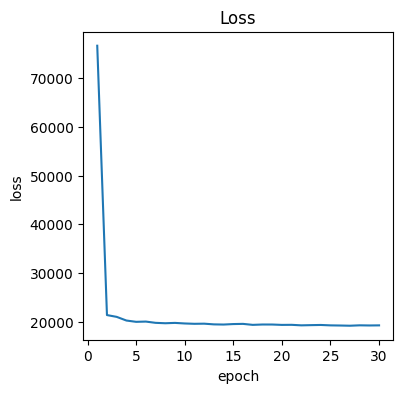

In [130]:
losses = np.array(loss_callback.val_loss)
model_utils.plot_loss(losses)
losses

# Reconstruction of model for each epoch of training

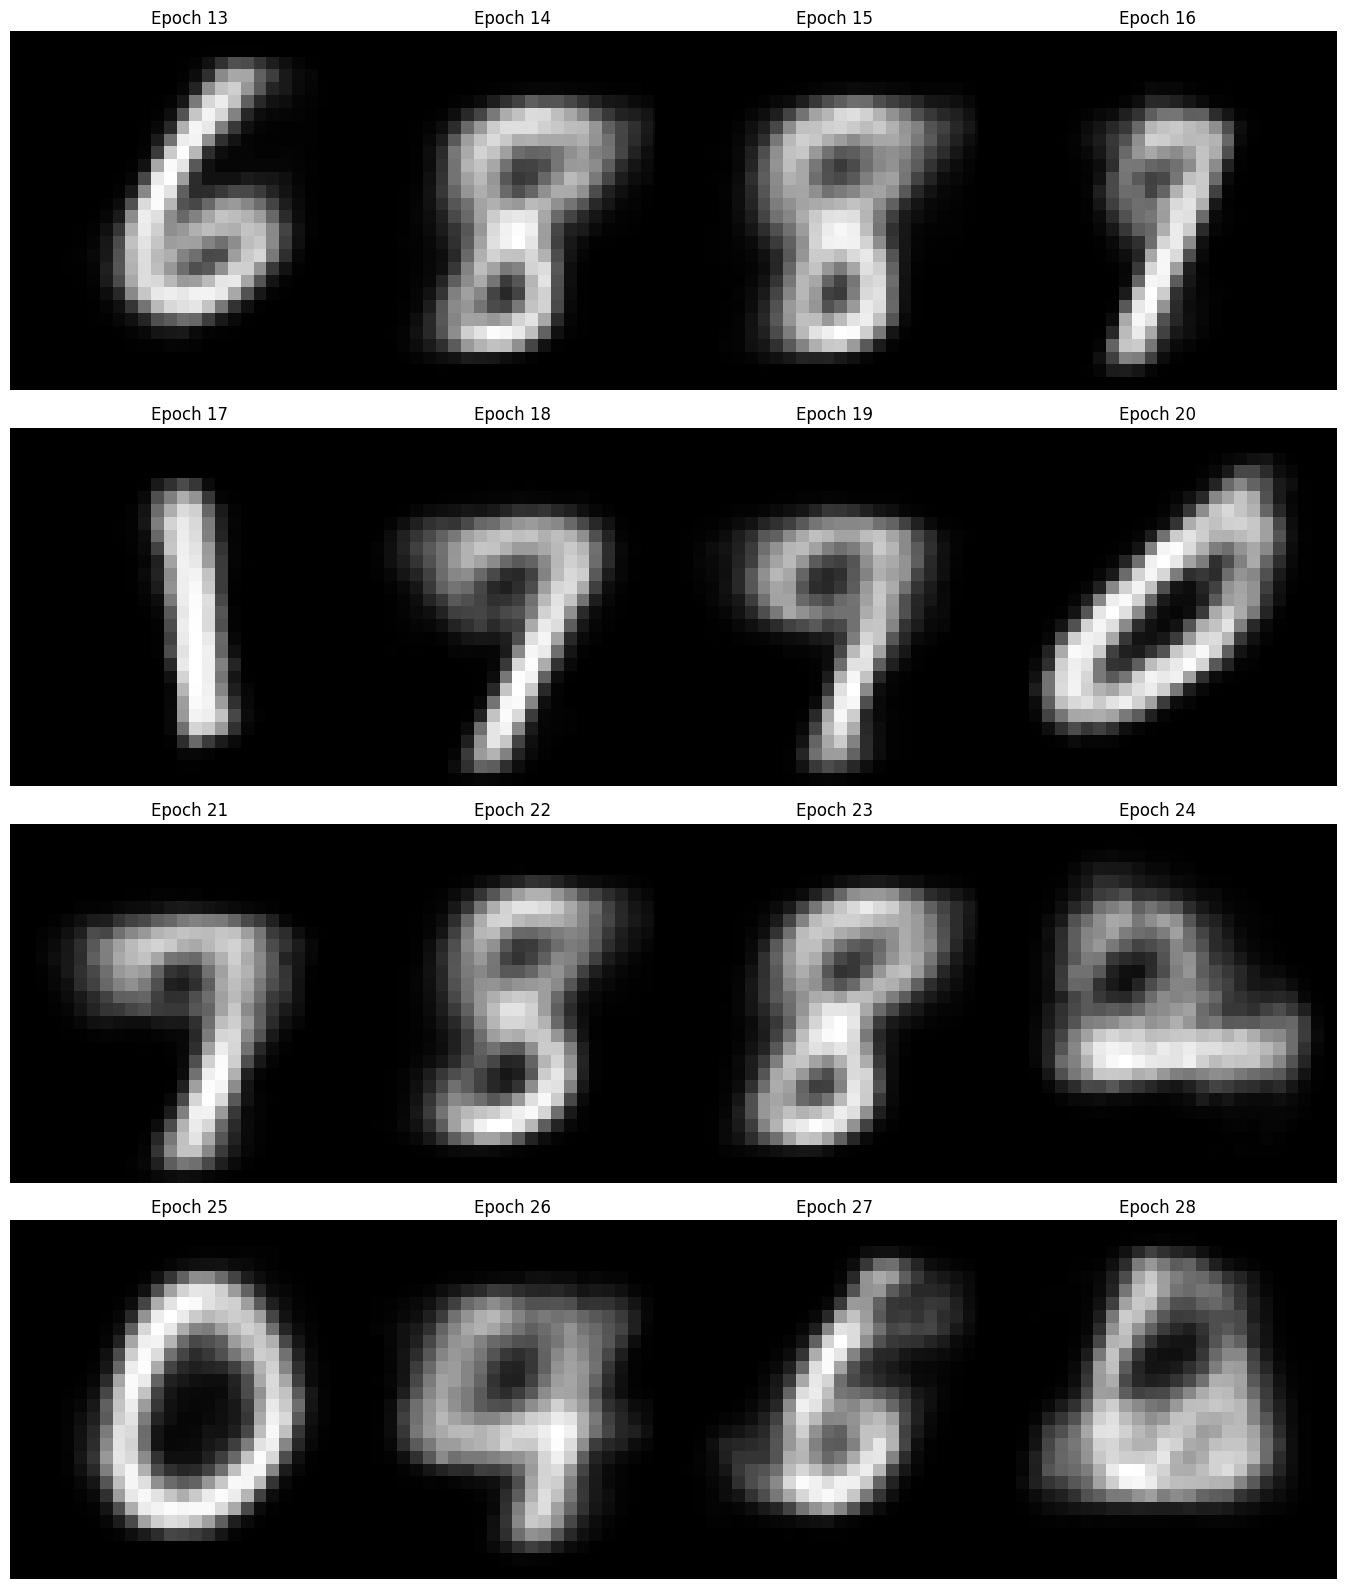

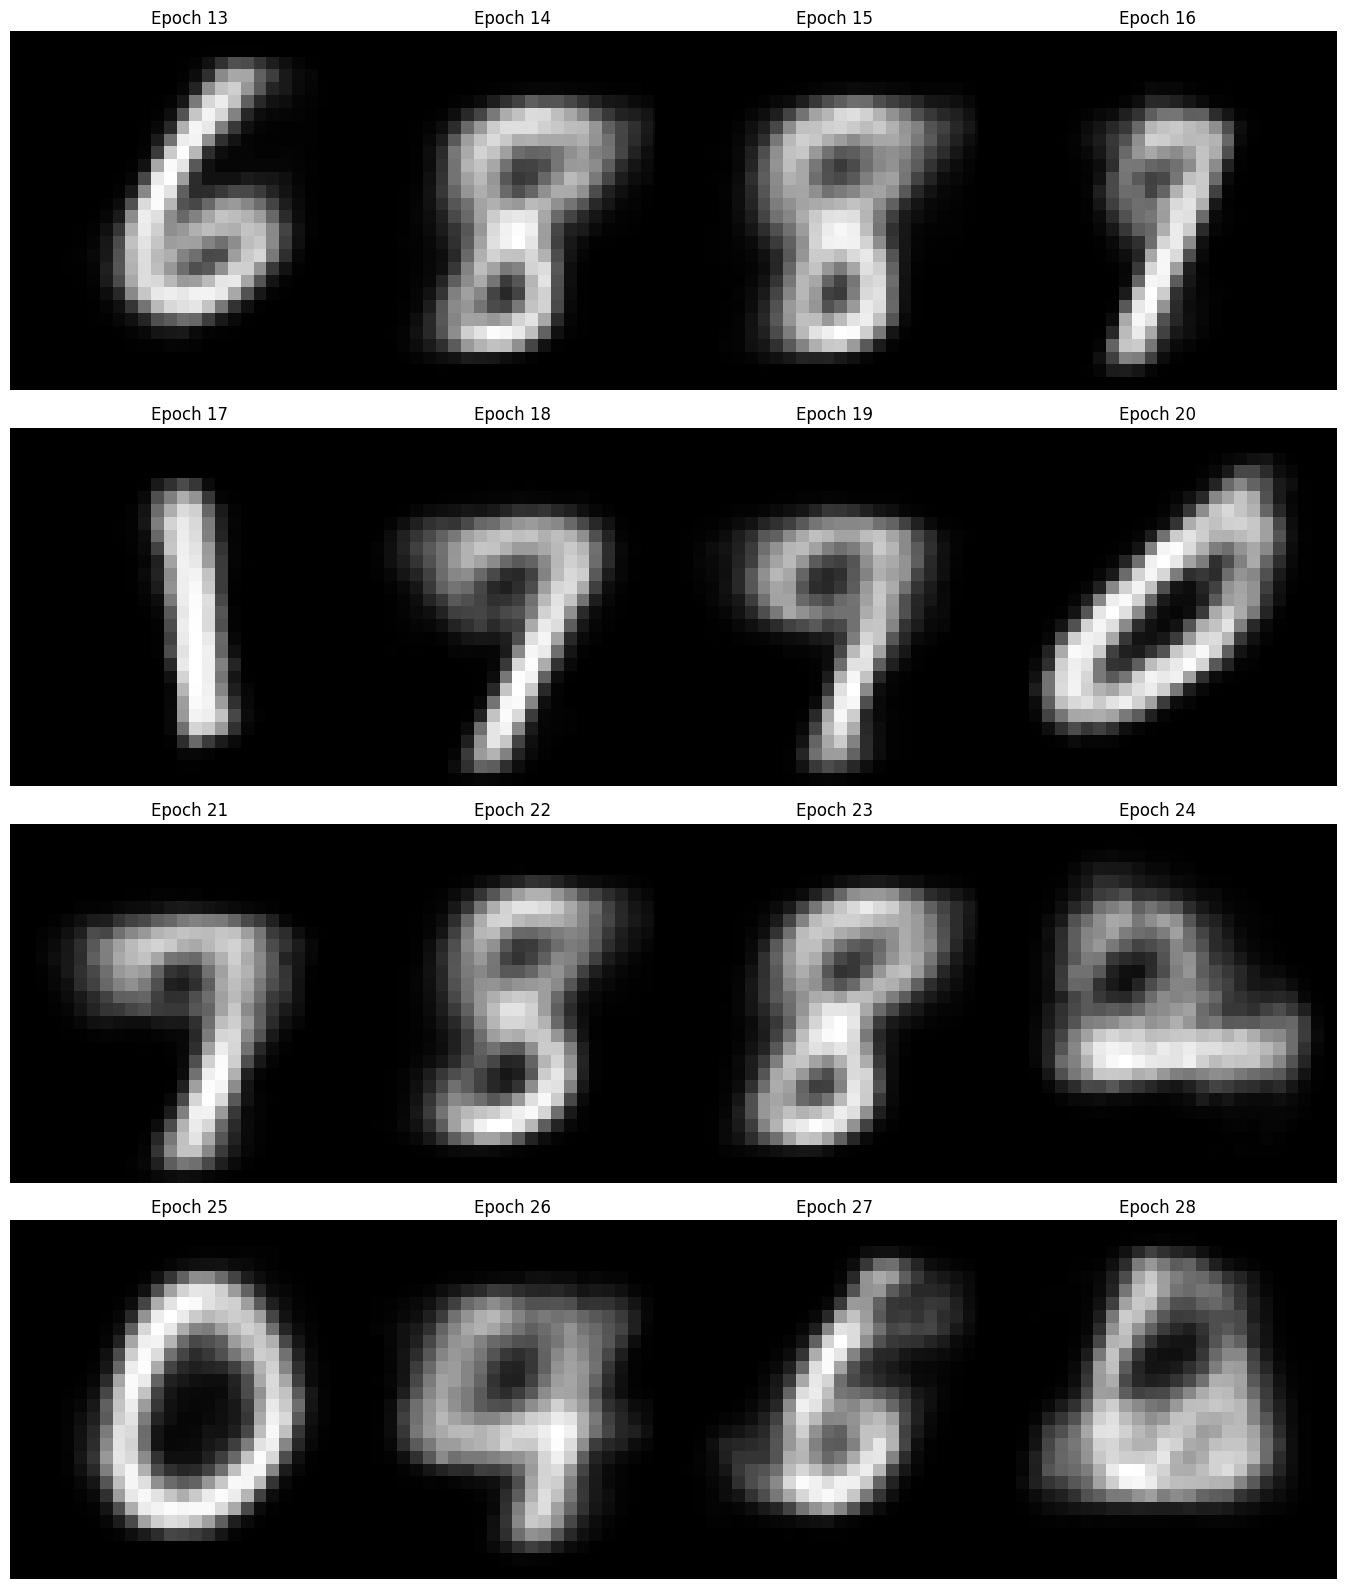

In [132]:
# Take first image of each batch of reconstructed images
images = reconstruct_cb.samples[-16:, 0, :, :].cpu().numpy()
start = cb_earlystopping.stopped_epoch - 16
model_utils.plot_image_reconstruction(images, num_cols=4, slim=20, start=start, **{"title": "Epoch"})

# Expected value in latent space for each number

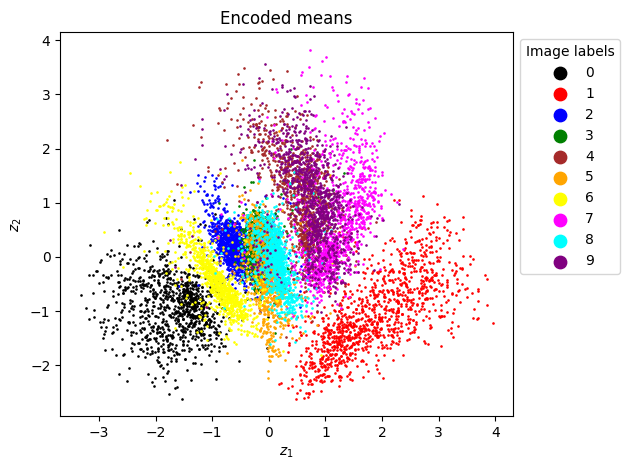

In [133]:
means_plot, labels = vae.encode_means(model.vae, val_loader)
plot_args = dict(title="Encoded means", xlabel=r"$z_1$", ylabel=r"$z_2$")
model_utils.plot_encoded(means_plot, labels, **plot_args)

# Reconstruction of equally spaced gaussian noise

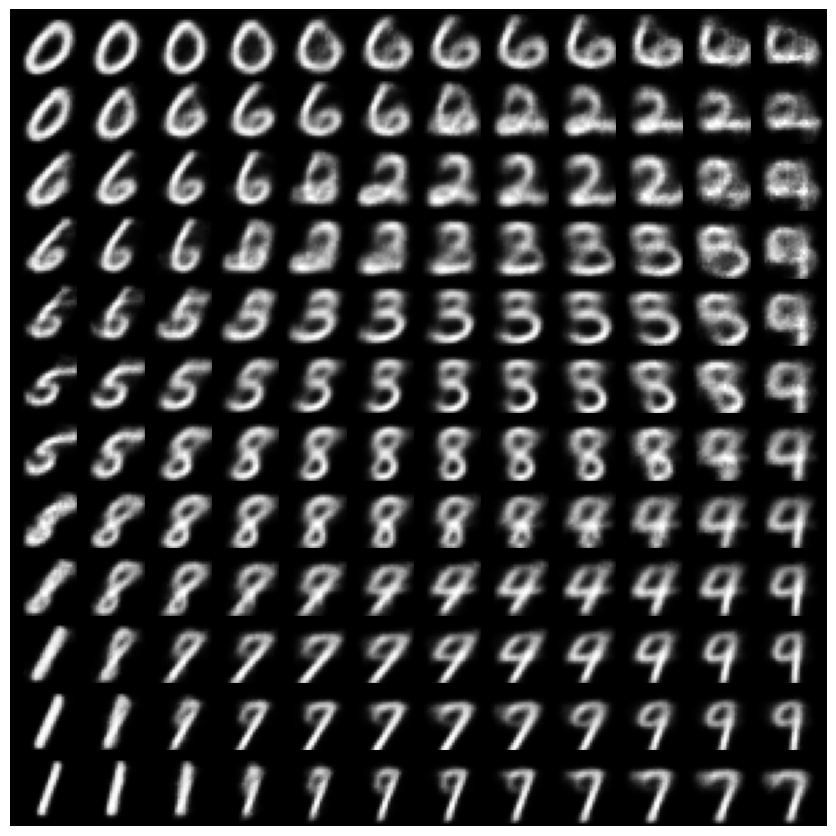

In [134]:
gauss_vals = model_utils.construct_gauss_grid(M=12)
decoded_imgs = model.vae.decode(gauss_vals).detach().numpy()
model_utils.plot_gauss_grid_imgs(decoded_imgs)